In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from typing import List
from tensorflow import GradientTape, reduce_mean
from utils.displays import display_image


# The dimensions of our input image.
img_width: int = 180
img_height: int = 180

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name: str = "conv5_block2_out"

In [2]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights.
model: Model = ResNet50V2(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer.
layer: Model = model.get_layer(name=layer_name)
feature_extractor: Model = Model(inputs=model.inputs, outputs=layer.output)

2022-04-14 16:41:56.881104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def compute_loss(
        _feature_extractor: Model,
        input_image: np.ndarray,
        _filter_index: int
) -> float:
    """
    :param _feature_extractor:
    :param input_image:
    :param _filter_index:
    :return:
    """

    activation: List[np.ndarray] = _feature_extractor(input_image)

    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2 : -2, 2 : -2, _filter_index]

    return reduce_mean(filter_activation)

In [4]:
@tf.function
def gradient_ascent_step(
        _feature_extractor: Model,
        image: np.ndarray,
        _filter_index: int,
        learning_rate: float
) -> np.ndarray:
    """
    :param _feature_extractor:
    :param image:
    :param _filter_index:
    :param learning_rate:
    :return:
    """

    with GradientTape() as tape:
        tape.watch(image)
        _loss = compute_loss(_feature_extractor, image, _filter_index)

    # Compute gradients.
    grads = tape.gradient(_loss, image)

    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads

    return image

In [8]:
def initialize_image() -> np.ndarray:
    """
    :return:
    """

    # We start from a gray image with some random noise.
    image: np.ndarray = tf.random.uniform((1, img_width, img_height, 3))

    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125].
    return (image - 0.5) * 0.25


def visualize_filter(_feature_extractor: Model, _filter_index: int) -> np.ndarray:
    """
    :param _feature_extractor:
    :param _filter_index:
    :return:
    """

    # We run gradient ascent for 20 steps.
    iterations: int = 30
    learning_rate: float = 10.0
    image: np.ndarray = initialize_image()

    for iteration in range(iterations):
        image: np.ndarray = gradient_ascent_step(
            _feature_extractor,
            image,
            _filter_index,
            learning_rate
        )

    # Decode the resulting input image.
    image: np.ndarray = deprocess_image(image[0].numpy())

    return image


def deprocess_image(image: np.ndarray) -> np.ndarray:
    """
    :param image:
    :return:
    """

    # Normalize array: center on 0., ensure variance is 0.15.
    image -= image.mean()
    image /= image.std() + 1e-5
    image *= 0.15

    # Center crop.
    image = image[25:-25, 25:-25, :]

    # Clip to [0, 1].
    image += 0.5
    image = np.clip(image, 0, 1)

    # Convert to RGB array.
    image *= 255
    image = np.clip(image, 0, 255).astype("uint8")

    return image

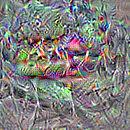

In [10]:
neuron_feature: np.ndarray = visualize_filter(feature_extractor, 0)
display_image(neuron_feature)

In [7]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin: int = 5
n: int = 8
cropped_width: int = img_width - 25 * 2
cropped_height: int = img_height - 25 * 2

width: int = n * cropped_width + (n - 1) * margin
height: int = n * cropped_height + (n - 1) * margin

stitched_filters: np.ndarray = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
        (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
        (cropped_height + margin) * j : (cropped_height + margin) * j + cropped_height,
        : ,] = img

keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

# from IPython.display import Image, display
#
#
# display(Image("stiched_filters.png"))

Processing filter 0


TypeError: visualize_filter() missing 1 required positional argument: '_filter_index'